In [1]:
import logging 
import os
import numpy as np
import matplotlib as plt
#import pyreadr
#import rpy2.robjects as ro
import scanpy as sc
import seaborn as sns
#from rpy2.robjects.packages import importr
#base = importr('base')

import scipy
import scipy.sparse as sparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import zarr

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

from statsmodels.stats.multitest import multipletests

import psutil

from gprofiler import GProfiler
# Basic import
import gseapy as gp

# If you need specific functions
from gseapy import enrichr, gsea, prerank, ssgsea

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Print total, used, and available RAM
mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / 1e9:.2f} GB")
print(f"Used RAM: {mem.used / 1e9:.2f} GB")
print(f"Available RAM: {mem.available / 1e9:.2f} GB")

Total RAM: 134.79 GB
Used RAM: 26.68 GB
Available RAM: 106.29 GB


In [3]:
def clear_globals():
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]

from IPython.display import display, Javascript

def restart_kernel():
    display(Javascript("Jupyter.notebook.kernel.restart_and_clear_output()"))

#restart_kernel()
#clear_globals()

In [4]:
print(gp.__version__)

1.1.8


In [5]:
#convert to AnnData after R operations
#experimented with zarr
def load_data(zarr=False):
    global adata
    adata = sc.read_h5ad("/home/jasonbanks/.synapseCache/480/144126480/scRNA-seqProcessedLabelledObject.h5ad")
    if zarr:
        adata.write_zarr("/home/jasonbanks/.synapseCache/480/144126480/scRNA-seqProcessedLabelledObject.zarr")  # Convert to Zarr format
        adata = sc.read_zarr("/home/jasonbanks/.synapseCache/480/144126480/scRNA-seqProcessedLabelledObject.zarr")  # Re-load from disk

mem_before = psutil.virtual_memory().used / 1e9
load_data()
mem_after = psutil.virtual_memory().used / 1e9

print(f"RAM Used: {mem_after - mem_before:.2f} GB")


#lazy load version
#adata = sc.read_h5ad("path/to/file", backed="r")

RAM Used: 24.72 GB


In [6]:
import scipy.sparse

print(adata)
print(type(adata.X))  # Should be 'scipy.sparse._csc.csc_matrix' or 'csr_matrix'

# Check memory size in GB
if scipy.sparse.issparse(adata.X):
    print(f"Sparse X memory: {adata.X.data.nbytes / 1e9:.2f} GB")
else:
    print(f"Dense X memory: {adata.X.nbytes / 1e9:.2f} GB")

AnnData object with n_obs × n_vars = 538266 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age'
    uns: 'version'
    layers: 'RNA_counts', 'RNA_data'
<class 'scipy.sparse._csc.csc_matrix'>
Sparse X memory: 3.05 GB


In [7]:
for layer in adata.layers.keys():
    layer_data = adata.layers[layer]
    if scipy.sparse.issparse(layer_data):
        print(f"Layer {layer}: {layer_data.data.nbytes / 1e9:.2f} GB (Sparse)")
    else:
        print(f"Layer {layer}: {layer_data.nbytes / 1e9:.2f} GB (Dense)")


Layer RNA_counts: 6.10 GB (Sparse)
Layer RNA_data: 6.10 GB (Sparse)


In [8]:
print(f"obs size: {adata.obs.memory_usage(deep=True).sum() / 1e9:.2f} GB")
print(f"var size: {adata.var.memory_usage(deep=True).sum() / 1e9:.2f} GB")

obs size: 0.10 GB
var size: 0.00 GB


In [9]:
def check_log_trans(adata):
    print(f"Min value: {adata.X.min()}, Max value: {adata.X.max()}")

    # Check for negative values
    has_negatives = (adata.X < 0).sum() > 0
    print(f"Contains negative values: {has_negatives}")

    # Plot histogram of values
    plt.figure(figsize=(10, 6))
    
    # Sample data from the sparse matrix (for very large matrices)
    if adata.n_obs * adata.n_vars > 1e6:  # If matrix is large
        # Convert a sample to dense for plotting
        sample_size = min(100000, adata.n_obs)
        sample_indices = np.random.choice(adata.n_obs, sample_size, replace=False)
        sample_data = adata.X[sample_indices].toarray().flatten()
    else:
        # Convert entire matrix to dense (if small enough)
        sample_data = adata.X.toarray().flatten()
    
    # Remove zeros for better visualization (optional)
    sample_data = sample_data[sample_data != 0]
    
    plt.hist(sample_data, bins=50)
    plt.title('Distribution of non-zero values in adata.X')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # Check for keys related to normalization in uns
    norm_keys = [k for k in adata.uns.keys() if any(x in k for x in ['norm', 'transform', 'log'])]
    print(f"Potential normalization keys in .uns: {norm_keys}")

Min value: 0.0, Max value: 8.959027290344238
Contains negative values: False


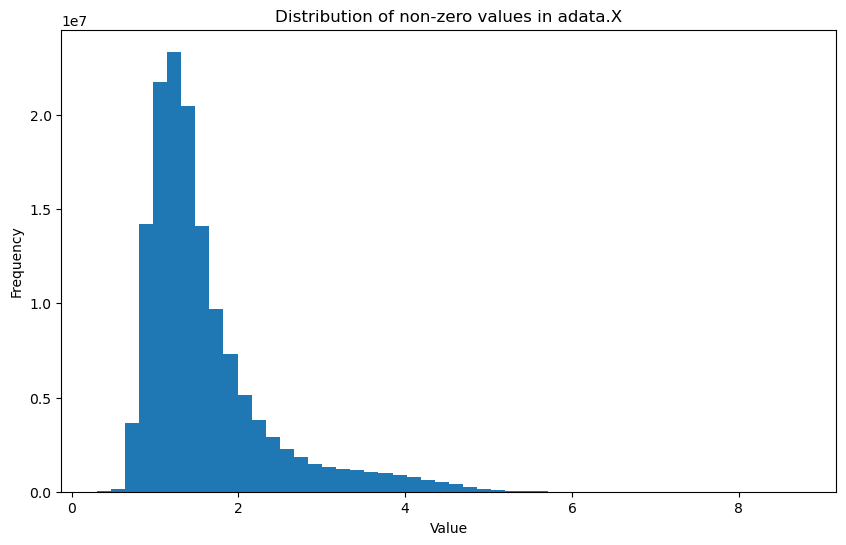

Potential normalization keys in .uns: []


In [10]:
check_log_trans(adata)

### Quality Control

In [11]:
#adata_original = adata.copy()
print(adata)

AnnData object with n_obs × n_vars = 538266 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age'
    uns: 'version'
    layers: 'RNA_counts', 'RNA_data'


In [ ]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [13]:
print(adata)

AnnData object with n_obs × n_vars = 538266 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age'
    var: 'mt', 'ribo', 'hb'
    uns: 'version'
    layers: 'RNA_counts', 'RNA_data'


In [14]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

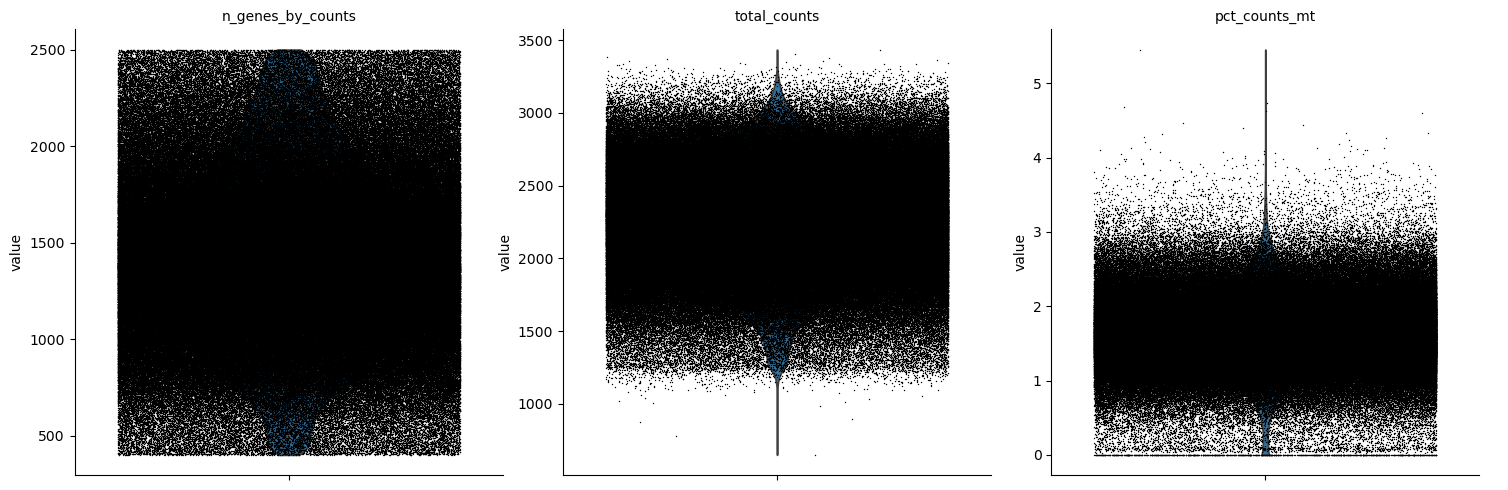

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [16]:
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [17]:
adata = adata[adata.obs.n_genes_by_counts >= 200, :]

In [18]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]

In [19]:
adata = adata[adata.obs.total_counts >= 1000, :]

In [ ]:
#genes per cell
n_genes_by_cell = (adata.X > 0).sum(axis=1).A1 if scipy.sparse.issparse(adata.X) else (adata.X > 0).sum(axis=1)

# keep only cells with > 500 genes
cell_mask = n_genes_by_cell >= 500
adata = adata[cell_mask].copy()

In [ ]:
#number of genes per cell
n_genes_by_cell = (adata.X > 0).sum(axis=1).A1 if scipy.sparse.issparse(adata.X) else (adata.X > 0).sum(axis=1)

#keep only cells with < 2500 genes
cell_mask = n_genes_by_cell < 2500
adata = adata[cell_mask].copy()

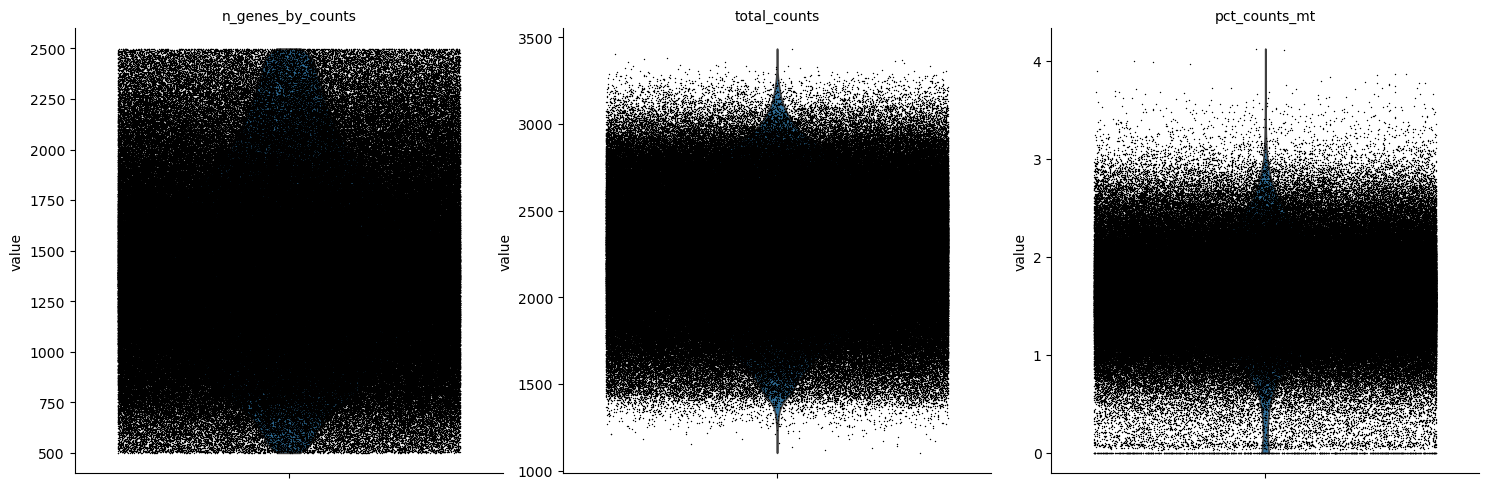

In [22]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

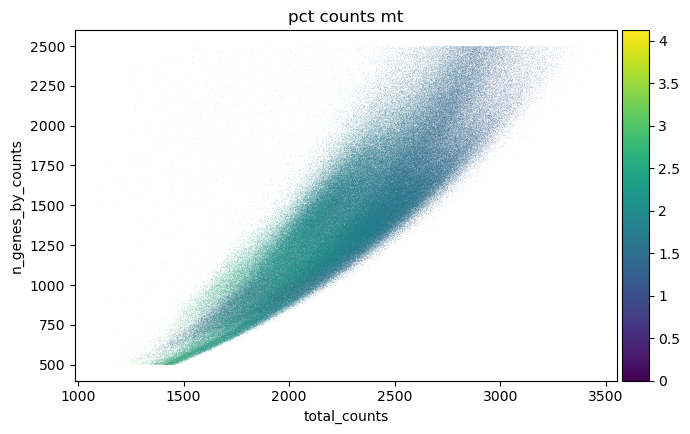

In [23]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [24]:
print(adata.obs.n_genes_by_counts)

AAACCTGAGGCGTACA-1-sample42    1889
AAACCTGAGGGAGTAA-1-sample42    1911
AAACCTGCAGCGATCC-1-sample42    1764
AAACCTGCATATGGTC-1-sample42    2112
AAACCTGCATTGAGCT-1-sample42    2095
                               ... 
TGAGAGGAGTGTTGAA-1-sample52    1577
TGATTTCCAACTAGAC-1-sample52    1499
TGGCCAGGTGTGGTTT-1-sample52    1723
TGTGTTTTCGGAAACG-1-sample52    1737
TGTGTCACATTCCTCG-1-sample52    1959
Name: n_genes_by_counts, Length: 532074, dtype: int64


In [25]:
print(adata.obs.pct_counts_mt)

AAACCTGAGGCGTACA-1-sample42    1.519088
AAACCTGAGGGAGTAA-1-sample42    1.538362
AAACCTGCAGCGATCC-1-sample42    1.606691
AAACCTGCATATGGTC-1-sample42    1.636372
AAACCTGCATTGAGCT-1-sample42    1.919513
                                 ...   
TGAGAGGAGTGTTGAA-1-sample52    1.469967
TGATTTCCAACTAGAC-1-sample52    1.564794
TGGCCAGGTGTGGTTT-1-sample52    1.495134
TGTGTTTTCGGAAACG-1-sample52    1.994408
TGTGTCACATTCCTCG-1-sample52    1.038658
Name: pct_counts_mt, Length: 532074, dtype: float32


### 4/30/2025 GO Age

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#top_genes = sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3.5, min_disp=0.5)
#adata = adata[:, adata.var.highly_variable]
#print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")

In [27]:
b_cell_types = ["B_BCR_GNLY", "B_Memory", "B_Atypical_Memory", "B_Naive", "Plasma cell"]  # Example labels from adata.obs['cell_type']
compare_cd4_cells = ["CD4_Naive_CCR7", "CD4_TCM_AQP3", "CD4_TEM_ANXA1", "CD4_TEM_GNLY", "CD4_Treg_FOXP3"]
compare_nk_cells = ["NK_CD56_Dim", "NK_CD56_Bright", "NK_Proliferating"]
compare_cd8_cells = ["CD8_TEM_GNLY", "CD8_Naive_LEF1", "CD8_TEM_CMC1", "CD8_MAIT_SLC4A10", "CD8_TEM_ZNF683", "CD8_TCM_HAVCR2"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#collect and organize
def process_go_results(results_dict, top_n=20, max_term_length=40):
    #dictionary to store p-values for each cell type and GO term
    all_go_terms = {} 
    #fictionary to map GO terms to their pathways
    go_term_to_pathway = {}  
    
    for cell_type, go_results in results_dict.items():
        if go_results is None or len(go_results) == 0:
            continue
            
        for _, row in go_results.iterrows():
            go_term_id = row['native']  #GO Term ID
            go_term_name = row['name']  #Function name
            p_value = row['p_value']
            
            pathway = row.get('term_name', '') 
            if not pathway:
                pathway = go_term_name
            
            display_name = f"{go_term_id}: {go_term_name}"
            
            if display_name not in all_go_terms:
                all_go_terms[display_name] = {}
                go_term_to_pathway[display_name] = pathway
            
            all_go_terms[display_name][cell_type] = p_value
    
    #convert to dataframe, fill non-significant
    go_df = pd.DataFrame(all_go_terms).T
    go_df = go_df.fillna(1.0)
    
    #-log10(p-value) for visualization
    neg_log_p_df = -np.log10(go_df)
    
    #top n most significance values across cell types
    neg_log_p_df['sum'] = neg_log_p_df.sum(axis=1)
    top_terms = neg_log_p_df.sort_values('sum', ascending=False).head(top_n).index
    
    #create dataframe for the heatmap
    heatmap_df = neg_log_p_df.loc[top_terms].drop('sum', axis=1)
    
    #return the heatmal as a datafram
    return heatmap_df

def plot_go_heatmap(results_dict, top_n=20, figsize=(12, 16), max_term_length=40, title="Enrichment Heatmap", title_cells="Cell Type"):
    #convert to df
    heatmap_df = process_go_results(results_dict, top_n)
    plt.figure(figsize=figsize)

    #color
    cmap = sns.color_palette("Reds", as_cmap=True)

    #heatmap
    ax = sns.heatmap(
        heatmap_df,
        cmap=cmap,
        linewidths=.5,
        annot=True,
        fmt='.1f', 
        cbar_kws={'label': '-log10(p-value)'}
    )
    
    #shorten labels for representation
    shortened_labels = []
    for term in heatmap_df.index:
        #term name after id
        if ": " in term:
            #retrive go_id and term_name
            go_id, term_name = term.split(": ", 1)
            
            if len(term_name) > max_term_length:
                shortened_term = term_name[:max_term_length].rsplit(' ', 1)[0] + '...'
            else:
                shortened_term = term_name
                
            #go_id for reference
            shortened_label = f"{go_id}: {shortened_term}"
        else:
            if len(term) > max_term_length:
                shortened_label = term[:max_term_length].rsplit(' ', 1)[0] + '...'
            else:
                shortened_label = term
                
        shortened_labels.append(shortened_label)
    
    #set shortended labels to y
    ax.set_yticklabels(shortened_labels)
    
    #titles/labels
    plt.title(title, fontsize=14)
    plt.ylabel('GO Terms', fontsize=12)
    plt.xlabel(title_cells, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return ax

# Usage
#function with your GO results dictionary to create the heatmap
#plot_go_heatmap(results_dict, top_n=20, figsize=(12, 16), title="GO Enrichment Across B Cell Subtypes", title_cells="B Cell Subtypes")
plt.savefig('b_cell_go_enrichment_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

### GO Ontology Functions

In [68]:
print(adata)

AnnData object with n_obs × n_vars = 532074 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'


In [69]:
sc.tl.rank_genes_groups(adata, groupby='secondary_type', method='wilcoxon')


/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packa

In [71]:
adata.uns['rank_genes_groups']['names']['CD4_Naive_CCR7']

array(['CCR7', 'LDHB', 'RPS5', ..., 'CD74', 'CLIC1', 'S100A4'],
      dtype=object)

In [43]:
adata.obs['primary_type'].value_counts()

primary_type
CD4T              138538
NK                116731
CD8T              108166
Monocytes_CD14     85784
B                  27717
gdT                18490
B_BCR_GNLY         14609
Monocytes_CD16     13408
mDC                 3133
pDC                 2555
Mega                1671
Plasma              1272
Name: count, dtype: int64

In [70]:
adata.obs['secondary_type'].value_counts()

secondary_type
NK_CD56_Dim          108005
Monocytes_CD14        85772
CD4_Naive_CCR7        58957
CD8_TEM_GNLY          40550
CD8_Naive_LEF1        32704
CD4_TCM_AQP3          32635
CD4_TEM_ANXA1         32100
CD8_TEM_CMC1          22574
gdT                   18490
B_BCR_GNLY            14631
Monocytes_CD16        13477
B_Memory              13077
B_Naive               11749
CD4_TEM_GNLY          10218
NK_CD56_Bright         7175
CD8_MAIT_SLC4A10       6712
CD4_Treg_FOXP3         4628
CD8_TEM_ZNF683         3834
mDC                    3076
B_Atypical_Memory      2873
pDC                    2555
CD8_TCM_HAVCR2         1792
Mega                   1671
NK_Proliferating       1551
Plasma cell            1268
Name: count, dtype: int64

In [167]:
def deg_marker_go(cells_comp_list, adata, is_primary=False, source=["GO:BP", "GO:MF", "GO:CC"], global_comp=False):
    results_dict_go = {}

    #adata limit to adata_b for expressed genes at the end
    check_col = 'primary_type' if is_primary else 'secondary_type'
    #adata_b = adata[adata.obs[check_col].isin(cells_comp_list)].copy()

    print([adata.obs[check_col].isin(cells_comp_list)])

    #print("Filtered adata_b shape:", adata_b.shape)
    #print("Unique values in check_col:", adata_b.obs[check_col].unique())

    #de analysis across all B cell types
    logger.info(f"Running rank_genes_groups on {check_col}")
    sc.tl.rank_genes_groups(adata, groupby=check_col, method='wilcoxon')

    #loop over each type
    for cell_type in cells_comp_list:
        logger.info(f"Processing cell type: {cell_type}")

        #subset size
        #adata_subset = adata_b[adata_b.obs[check_col] == cell_type].copy()
        #print(adata_subset)
        #print(f"{cell_type} subset size:", adata_subset.n_obs)
        #print(adata_subset.obs[check_col].unique())

        #ranked marker genes
        marker_genes = sc.get.rank_genes_groups_df(adata, group=cell_type)
        #print("Total marker genes:", marker_genes.shape[0])
        #print(marker_genes.describe())

        print("marker genes:")
        #print(marker_genes)
        #print(marker_genes.head(10))  # first 10 genes

        #print("mg sort values")
        #print(marker_genes.sort_values(by='logfoldchanges', ascending=False).head(10))
        #print(marker_genes.sort_values(by='pvals_adj').head(10))

        #deg filter
        marker_genes_filtered = marker_genes[
            (marker_genes['pvals_adj'] < 0.25) &
            (marker_genes['logfoldchanges'] > 0.5)
        ]
        marker_gene_list = marker_genes_filtered['names'].tolist()

        #print(f"Number of filtered marker genes for {cell_type}: {len(marker_gene_list)}")
        #print("Filtered gene list preview:", marker_gene_list[:10])

        if not marker_gene_list:
            logger.warning(f"No DEGs for {cell_type}. Skipping GO.")
            continue

        #all genes in b cells as background
        expressed_genes = adata.raw.var_names.tolist() if adata.raw else adata.var_names.tolist()

        print(source)

        logger.info(f"Running GO enrichment for: {cell_type}")
        if global_comp == False:
            gp = GProfiler(return_dataframe=True)
            go_results = gp.profile(
                organism='hsapiens',
                query=marker_gene_list,
                sources=source,
                domain_scope="custom",
                background=expressed_genes
            )
        elif global_comp == True:
            print("global")
            gp = GProfiler(return_dataframe=True)
            go_results = gp.profile(
                organism='hsapiens',
                query=marker_gene_list,
                sources=source,
            )

        # save res to dictionary
        logger.info(f"Saving GO results for {cell_type}")
        results_dict_go[cell_type] = go_results

    return results_dict_go


In [166]:
#go_analysis_b_cell_total = deg_marker_go(b_cell_types, adata, global_comp=False)
go_analysis_b_cell_total = deg_marker_go(b_cell_types, adata)

INFO:__main__:Running rank_genes_groups on secondary_type


[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False
AAACCTGCAGCGATCC-1-sample42    False
AAACCTGCATATGGTC-1-sample42     True
AAACCTGCATTGAGCT-1-sample42     True
                               ...  
TGAGAGGAGTGTTGAA-1-sample52    False
TGATTTCCAACTAGAC-1-sample52    False
TGGCCAGGTGTGGTTT-1-sample52    False
TGTGTTTTCGGAAACG-1-sample52    False
TGTGTCACATTCCTCG-1-sample52    False
Name: secondary_type, Length: 532074, dtype: bool]


/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packa

marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_BCR_GNLY
INFO:__main__:Processing cell type: B_Memory
INFO:__main__:Running GO enrichment for: B_Memory


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_Memory
INFO:__main__:Processing cell type: B_Atypical_Memory
INFO:__main__:Running GO enrichment for: B_Atypical_Memory


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_Atypical_Memory
INFO:__main__:Processing cell type: B_Naive
INFO:__main__:Running GO enrichment for: B_Naive


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_Naive
INFO:__main__:Processing cell type: Plasma cell
INFO:__main__:Running GO enrichment for: Plasma cell


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for Plasma cell


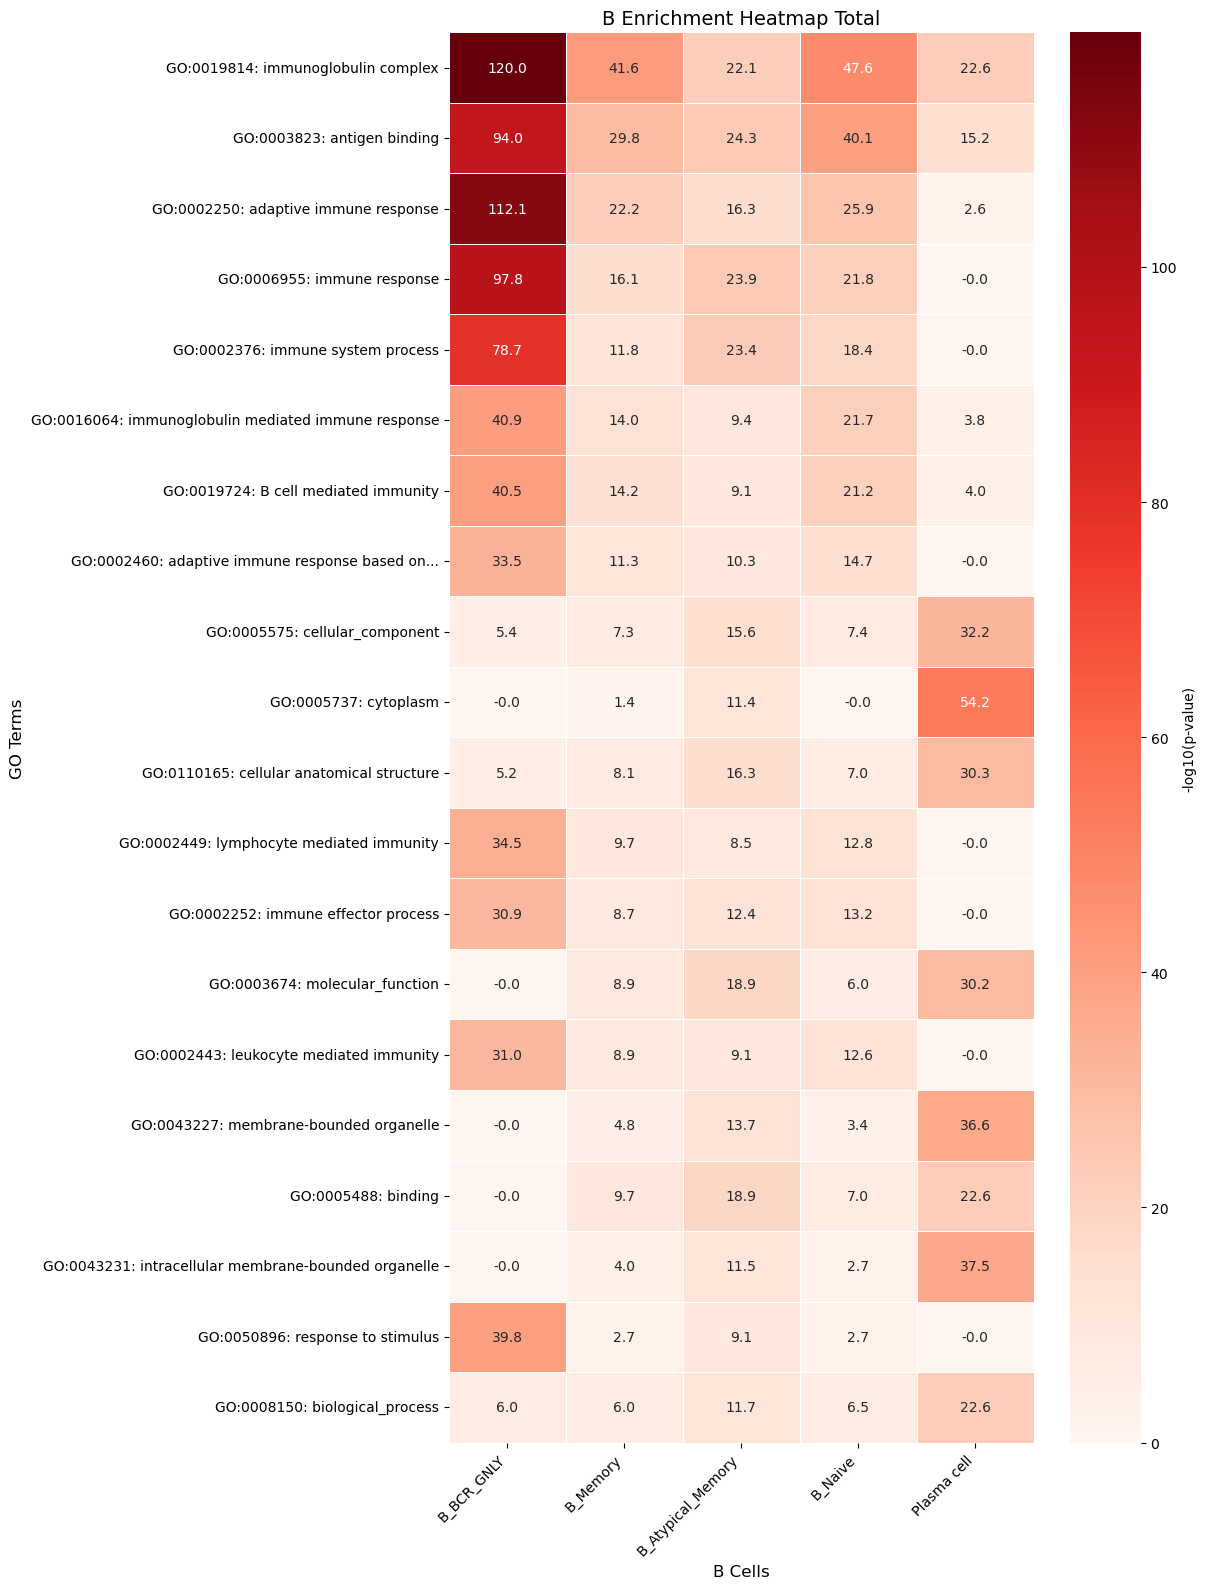

In [ ]:
plot_go_heatmap(go_analysis_b_cell_total, title="B Enrichment Heatmap Total", title_cells="B Cells")
#plt.savefig('B_cell_go_enrichment_heatmap_expressed_backgroud_total.png', dpi=300, bbox_inches='tight')
#plt.savefig('B_cell_go_enrichment_heatmap_expressed_backgroud_total_global.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


AnnData object with n_obs × n_vars = 138538 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'
[AAACCTGAGGCGTACA-1-sample42     True
AAACCTGAGGGAGTAA-1-sample42     True

INFO:__main__:Processing cell type: CD4_Naive_CCR7
INFO:__main__:Running GO enrichment for: CD4_Naive_CCR7


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_Naive_CCR7
INFO:__main__:Processing cell type: CD4_TCM_AQP3
INFO:__main__:Running GO enrichment for: CD4_TCM_AQP3


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_TCM_AQP3
INFO:__main__:Processing cell type: CD4_TEM_ANXA1
INFO:__main__:Running GO enrichment for: CD4_TEM_ANXA1


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_TEM_ANXA1
INFO:__main__:Processing cell type: CD4_TEM_GNLY
INFO:__main__:Running GO enrichment for: CD4_TEM_GNLY


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_TEM_GNLY
INFO:__main__:Processing cell type: CD4_Treg_FOXP3
INFO:__main__:Running GO enrichment for: CD4_Treg_FOXP3


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_Treg_FOXP3


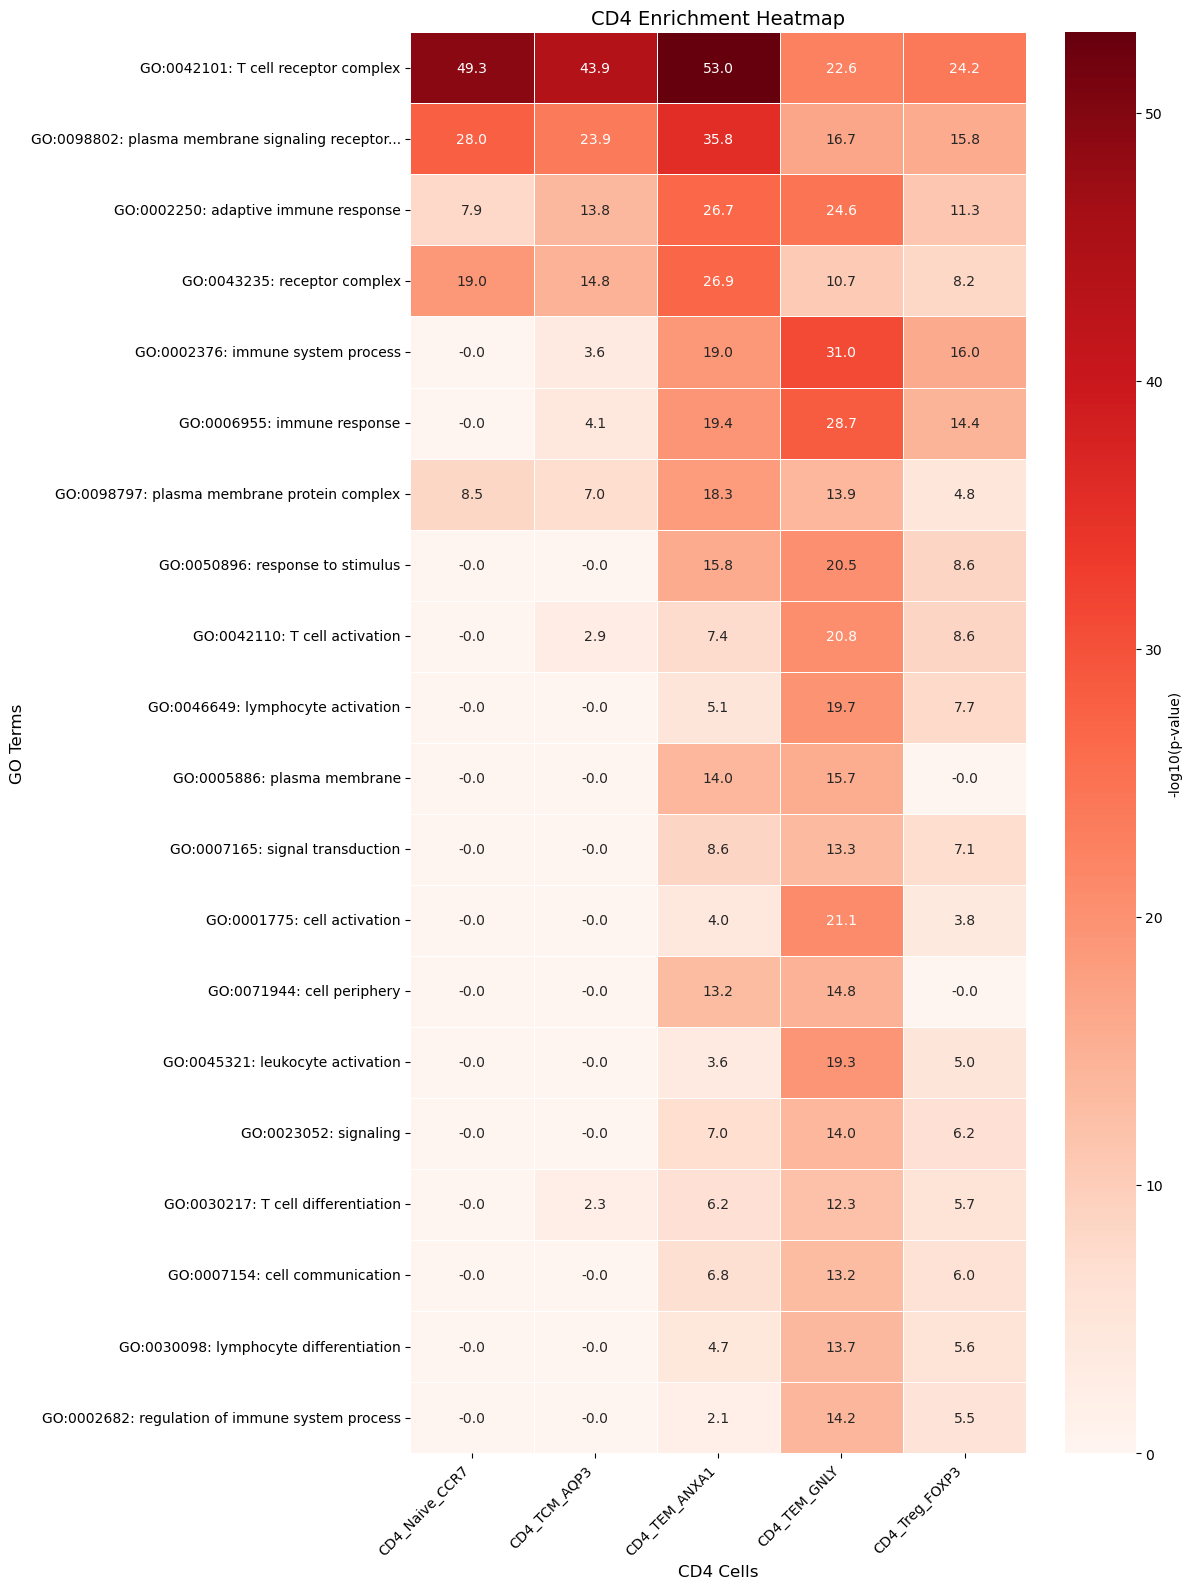

In [75]:
go_analysis_CD4 = deg_marker_go(compare_cd4_cells, adata)
plot_go_heatmap(go_analysis_CD4, title="CD4 Enrichment Heatmap", title_cells="CD4 Cells")
plt.savefig('CD4_cell_go_enrichment_heatmap_total.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False
AAACCTGCAGCGATCC-1-sample42     True
AAACCTGCATATGGTC-1-sample42    False
AAACCTGCATTGAGCT-1-sample42    False
                               ...  
TGAGAGGAGTGTTGAA-1-sample52    False
TGATTTCCAACTAGAC-1-sample52     True
TGGCCAGGTGTGGTTT-1-sample52    False
TGTGTTTTCGGAAACG-1-sample52    False
TGTGTCACATTCCTCG-1-sample52     True
Name: secondary_type, Length: 532074, dtype: bool]


/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packa

marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TEM_GNLY
INFO:__main__:Processing cell type: CD8_Naive_LEF1
INFO:__main__:Running GO enrichment for: CD8_Naive_LEF1


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_Naive_LEF1
INFO:__main__:Processing cell type: CD8_TEM_CMC1
INFO:__main__:Running GO enrichment for: CD8_TEM_CMC1


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TEM_CMC1
INFO:__main__:Processing cell type: CD8_MAIT_SLC4A10
INFO:__main__:Running GO enrichment for: CD8_MAIT_SLC4A10


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_MAIT_SLC4A10
INFO:__main__:Processing cell type: CD8_TEM_ZNF683
INFO:__main__:Running GO enrichment for: CD8_TEM_ZNF683


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TEM_ZNF683
INFO:__main__:Processing cell type: CD8_TCM_HAVCR2
INFO:__main__:Running GO enrichment for: CD8_TCM_HAVCR2


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TCM_HAVCR2


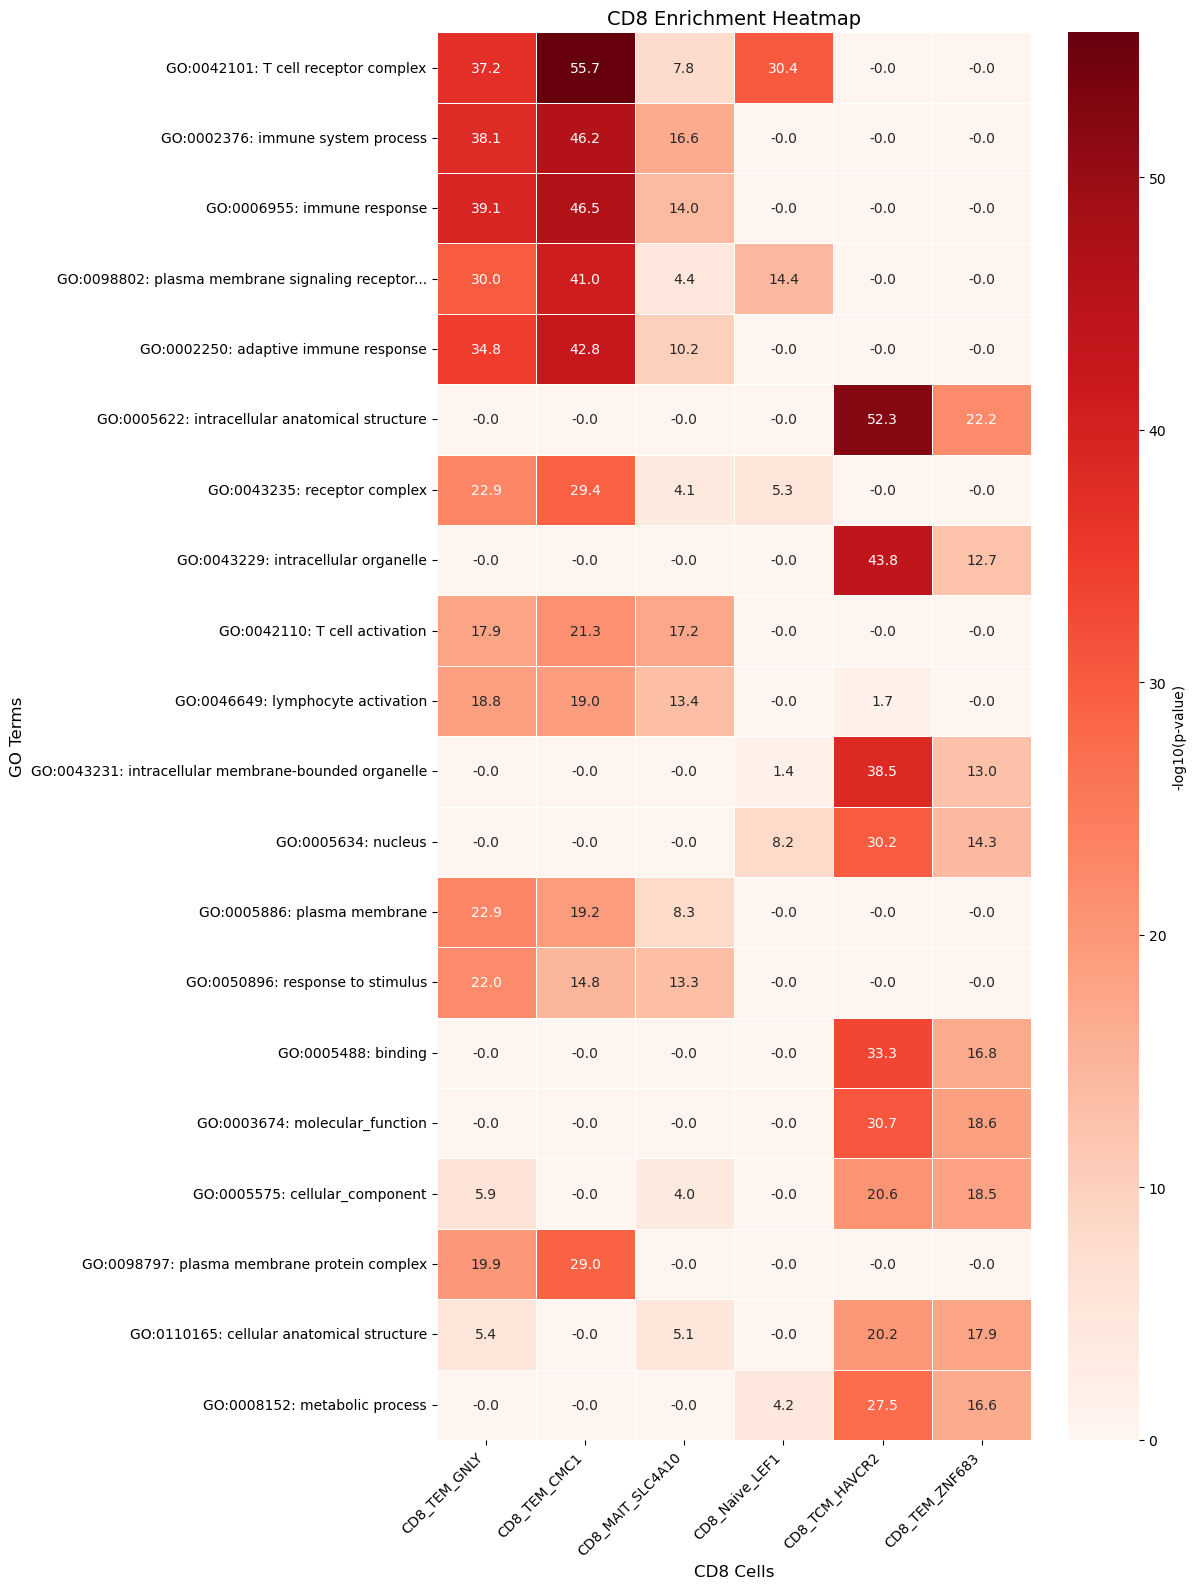

In [168]:
go_analysis_CD8 = deg_marker_go(compare_cd8_cells, adata)
plot_go_heatmap(go_analysis_CD8, title="CD8 Enrichment Heatmap", title_cells="CD8 Cells")
plt.savefig('CD8_cell_go_enrichment_heatmap_total.png', dpi=1200, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False
AAACCTGCAGCGATCC-1-sample42    False
AAACCTGCATATGGTC-1-sample42    False
AAACCTGCATTGAGCT-1-sample42    False
                               ...  
TGAGAGGAGTGTTGAA-1-sample52    False
TGATTTCCAACTAGAC-1-sample52    False
TGGCCAGGTGTGGTTT-1-sample52    False
TGTGTTTTCGGAAACG-1-sample52    False
TGTGTCACATTCCTCG-1-sample52    False
Name: secondary_type, Length: 532074, dtype: bool]


/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jasonbanks/anaconda3/envs/bio_project_analysis/lib/python3.9/site-packa

marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for NK_CD56_Dim
INFO:__main__:Processing cell type: NK_CD56_Bright
INFO:__main__:Running GO enrichment for: NK_CD56_Bright


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for NK_CD56_Bright
INFO:__main__:Processing cell type: NK_Proliferating
INFO:__main__:Running GO enrichment for: NK_Proliferating


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for NK_Proliferating


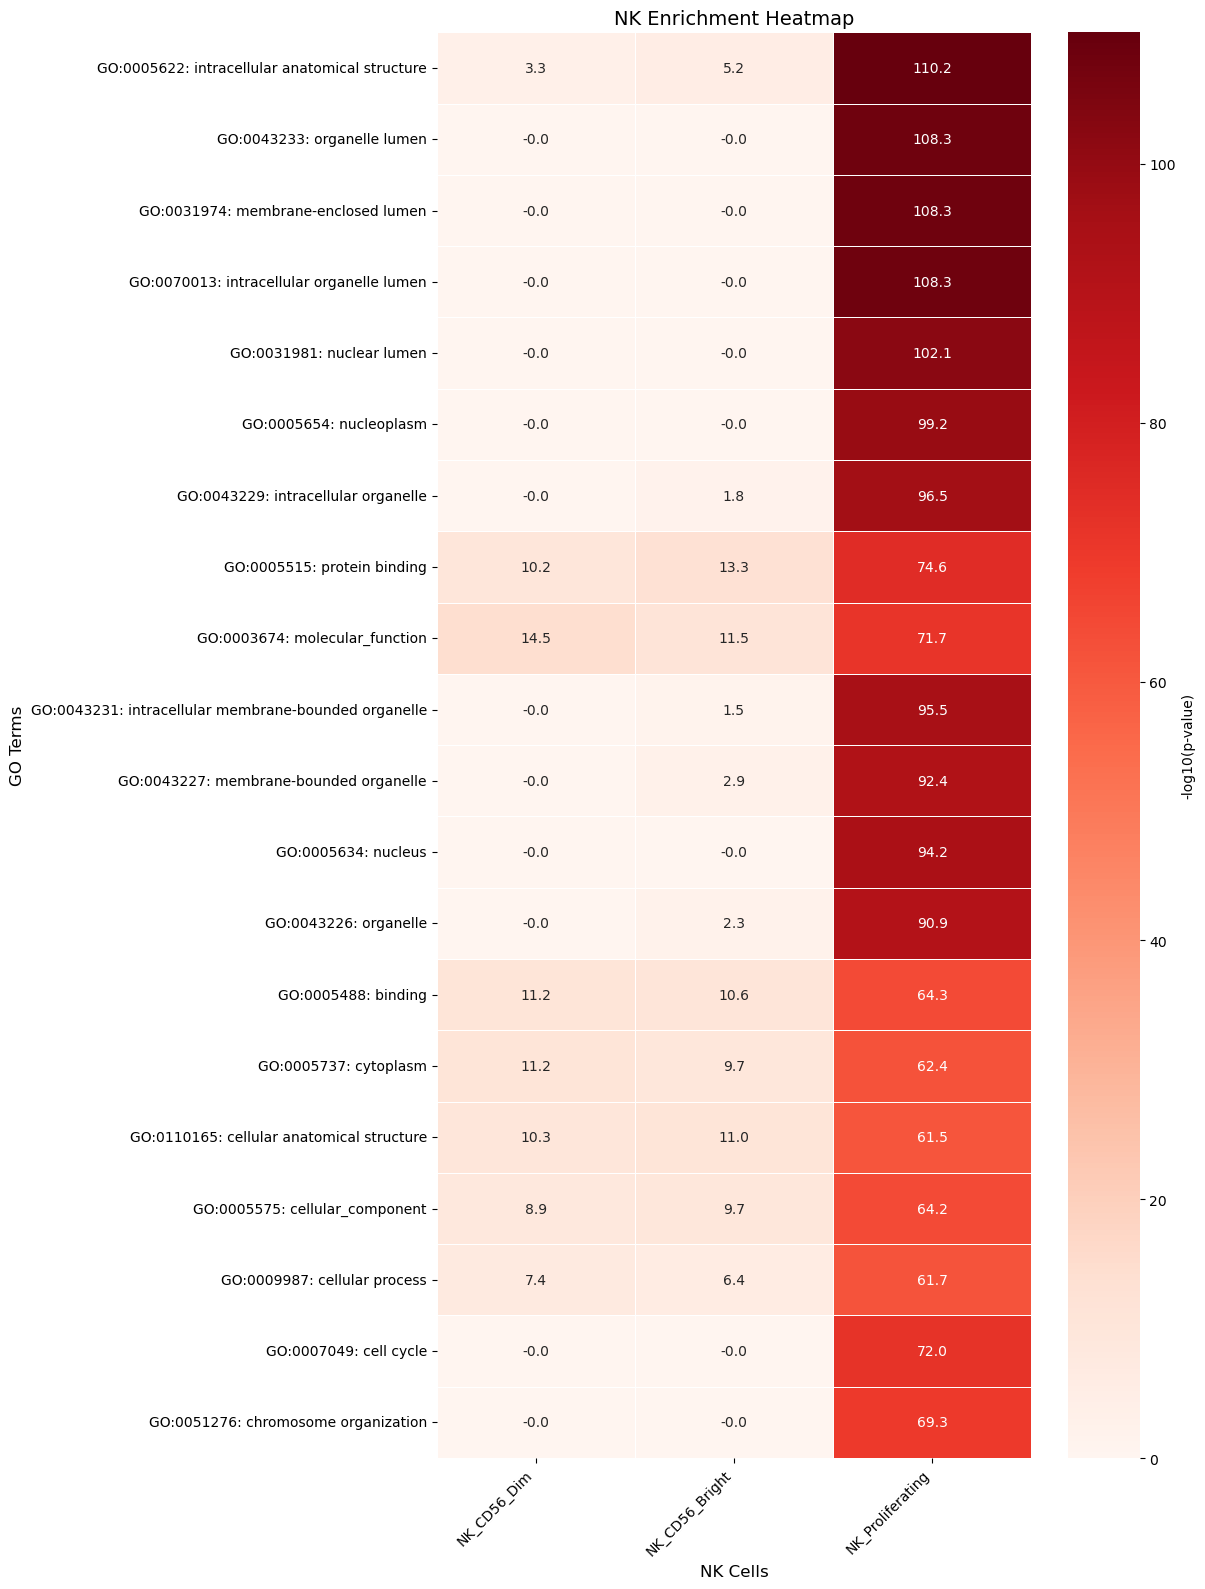

In [169]:
#ignore proliferating for now
go_analysis_nk = deg_marker_go(compare_nk_cells, adata)
plot_go_heatmap(go_analysis_nk, title="NK Enrichment Heatmap", title_cells="NK Cells")
plt.savefig('NK_cell_go_enrichment_heatmap_total_fix.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


AnnData object with n_obs × n_vars = 116731 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'
[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False

INFO:__main__:Processing cell type: NK_CD56_Dim
INFO:__main__:Running GO enrichment for: NK_CD56_Dim


marker genes:
['GO:BP']


INFO:__main__:Saving GO results for NK_CD56_Dim
INFO:__main__:Processing cell type: NK_CD56_Bright
INFO:__main__:Running GO enrichment for: NK_CD56_Bright


marker genes:
['GO:BP']


INFO:__main__:Saving GO results for NK_CD56_Bright
INFO:__main__:Processing cell type: NK_Proliferating
INFO:__main__:Running GO enrichment for: NK_Proliferating


marker genes:
['GO:BP']


INFO:__main__:Saving GO results for NK_Proliferating


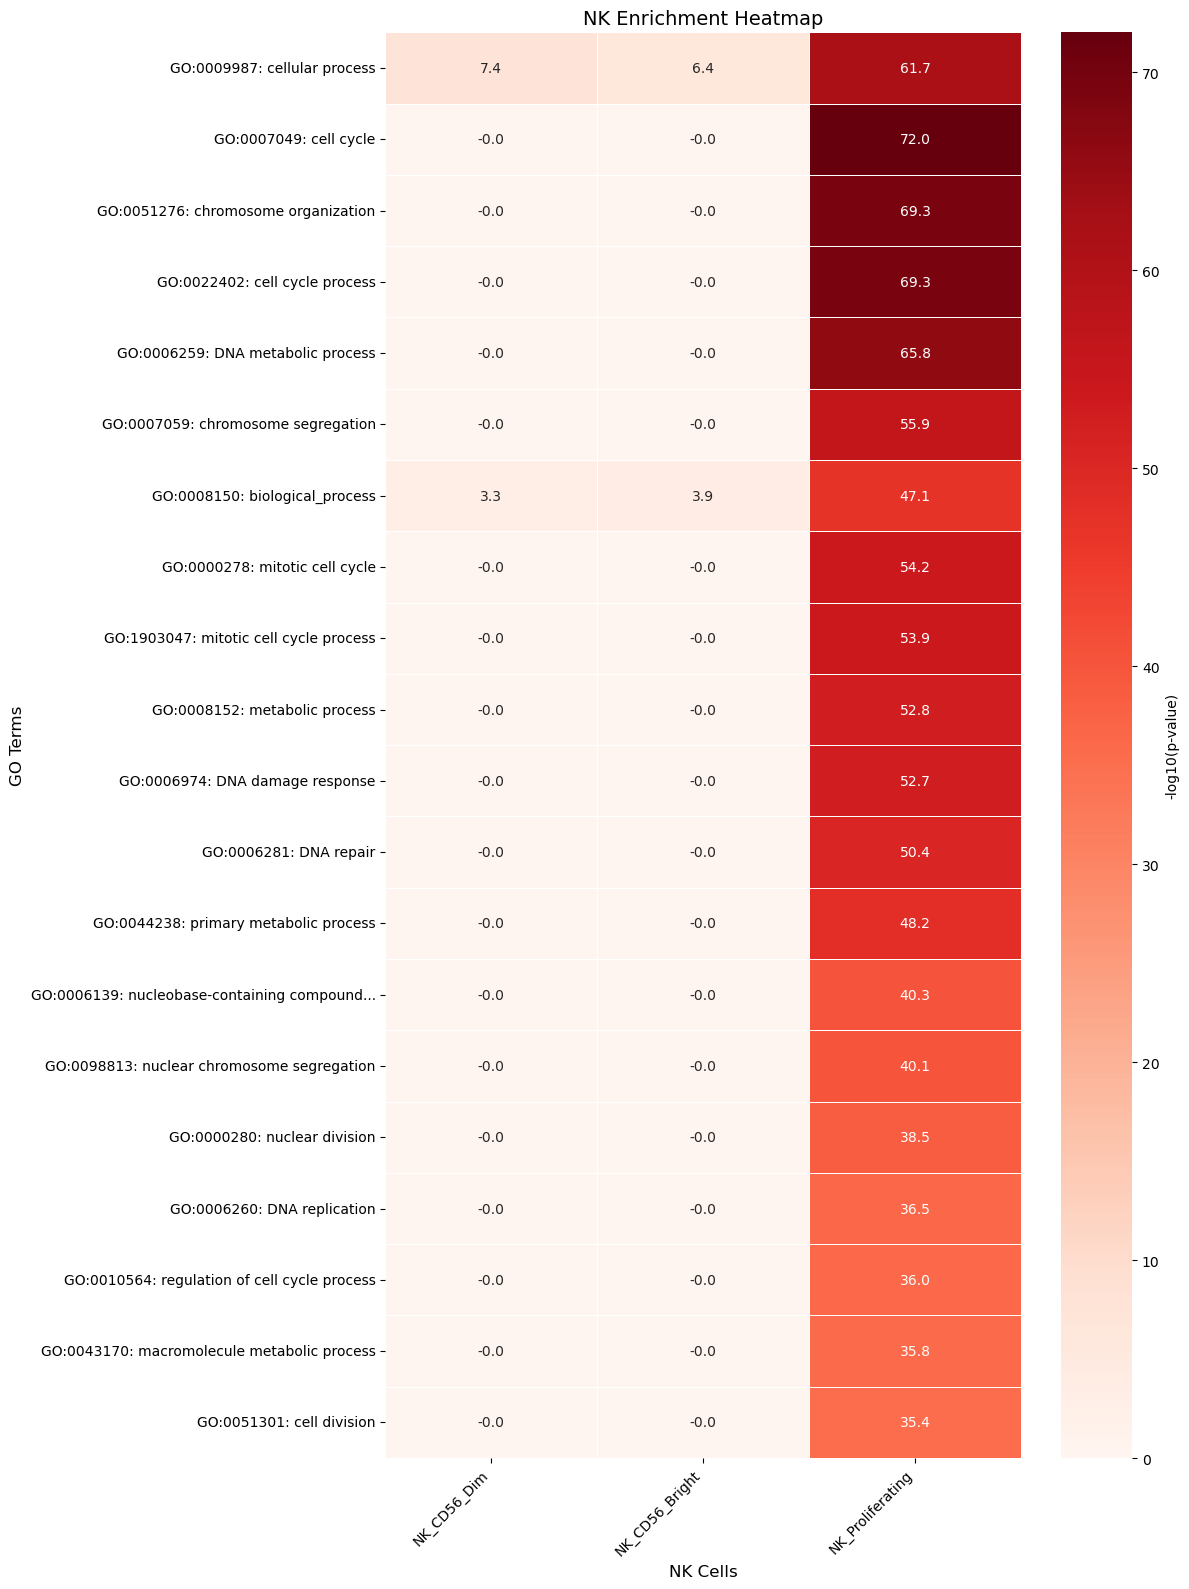

In [ ]:
go_analysis_nk_bp_only = deg_marker_go(compare_nk_cells, adata, source=["GO:BP"])
plot_go_heatmap(go_analysis_nk_bp_only, title="NK Enrichment Heatmap", title_cells="NK Cells")
plt.savefig('NK_cell_go_enrichment_heatmap_total_bp_only.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


AnnData object with n_obs × n_vars = 116731 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'
[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False

INFO:__main__:Processing cell type: NK_CD56_Dim
INFO:__main__:Running GO enrichment for: NK_CD56_Dim


marker genes:
['GO:BP', 'KEGG', 'REAC']


INFO:__main__:Saving GO results for NK_CD56_Dim
INFO:__main__:Processing cell type: NK_CD56_Bright
INFO:__main__:Running GO enrichment for: NK_CD56_Bright


marker genes:
['GO:BP', 'KEGG', 'REAC']


INFO:__main__:Saving GO results for NK_CD56_Bright
INFO:__main__:Processing cell type: NK_Proliferating
INFO:__main__:Running GO enrichment for: NK_Proliferating


marker genes:
['GO:BP', 'KEGG', 'REAC']


INFO:__main__:Saving GO results for NK_Proliferating


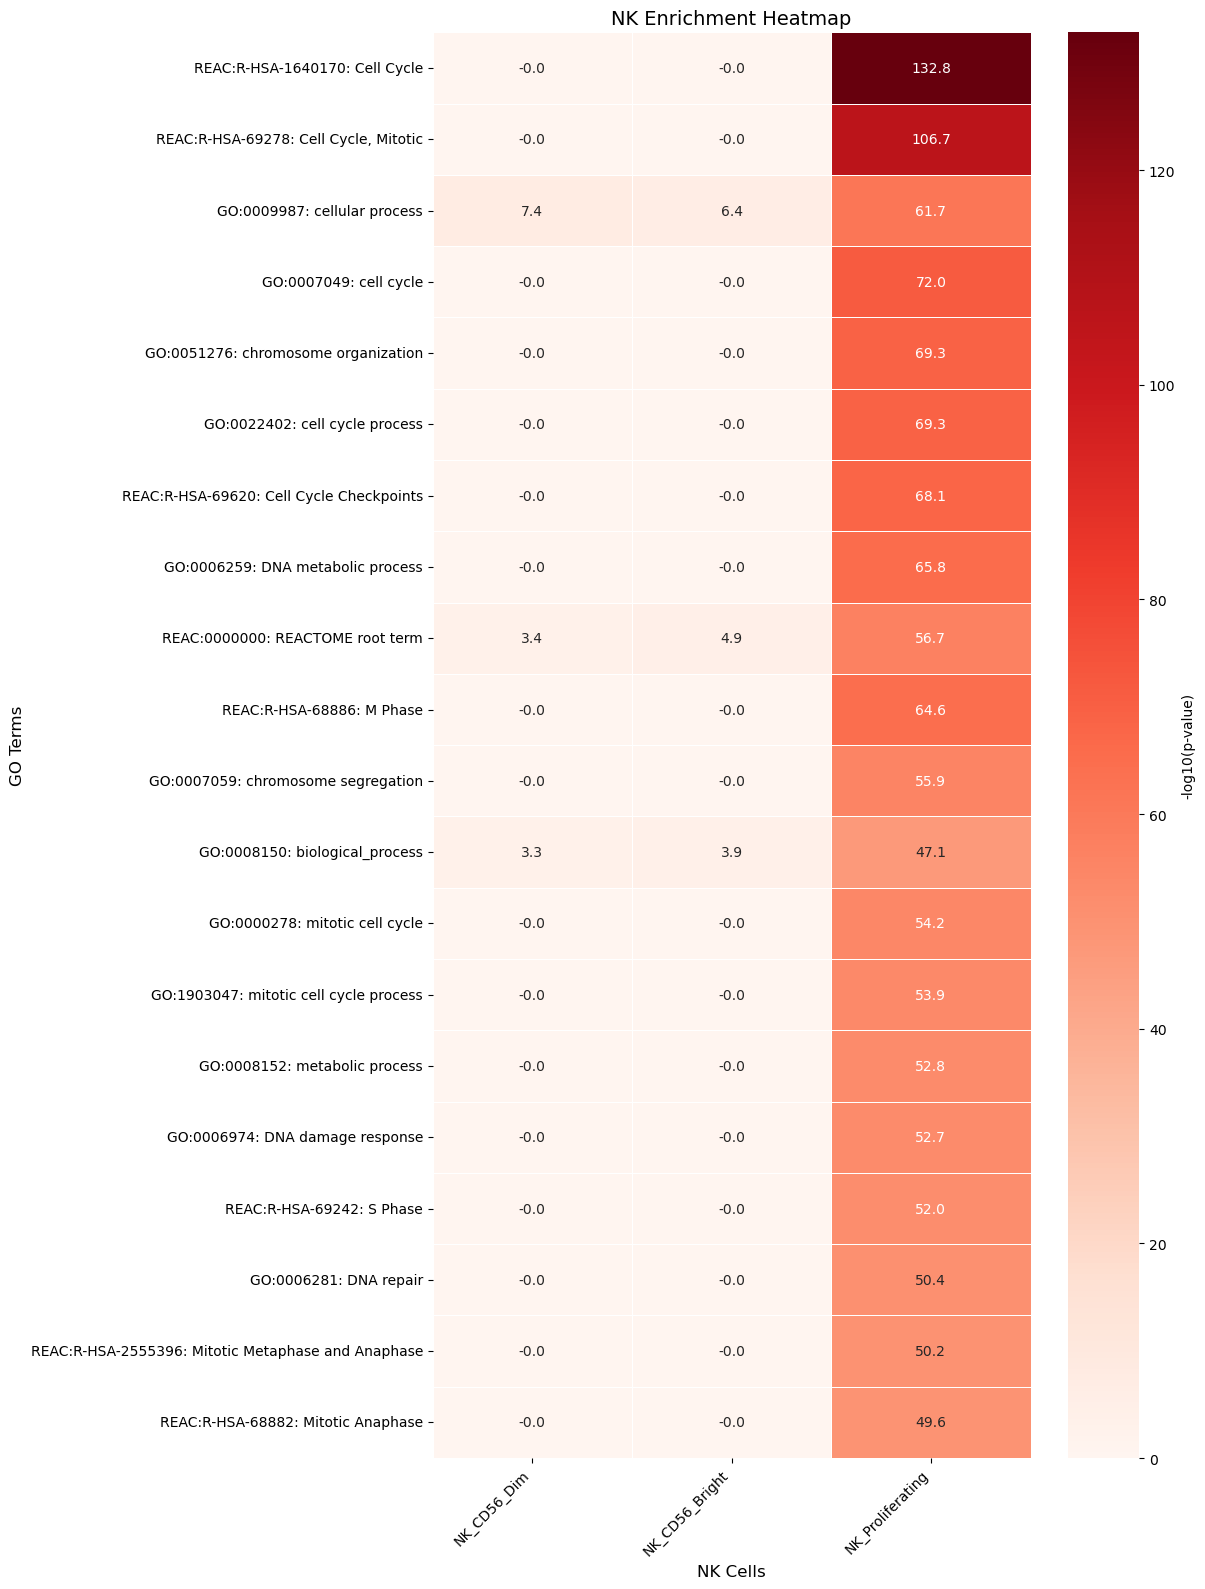

In [81]:
go_analysis_nk_bp_only = deg_marker_go(compare_nk_cells, adata, source=["GO:BP", "KEGG", "REAC"])
plot_go_heatmap(go_analysis_nk_bp_only, title="NK Enrichment Heatmap", title_cells="NK Cells")
plt.savefig('NK_cell_go_enrichment_heatmap_total_bp_kegg_reac.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


AnnData object with n_obs × n_vars = 115180 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'
[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False

INFO:__main__:Processing cell type: NK_CD56_Dim
INFO:__main__:Running GO enrichment for: NK_CD56_Dim


marker genes:
['GO:BP', 'KEGG', 'REAC']


INFO:__main__:Saving GO results for NK_CD56_Dim
INFO:__main__:Processing cell type: NK_CD56_Bright
INFO:__main__:Running GO enrichment for: NK_CD56_Bright


marker genes:
['GO:BP', 'KEGG', 'REAC']


INFO:__main__:Saving GO results for NK_CD56_Bright


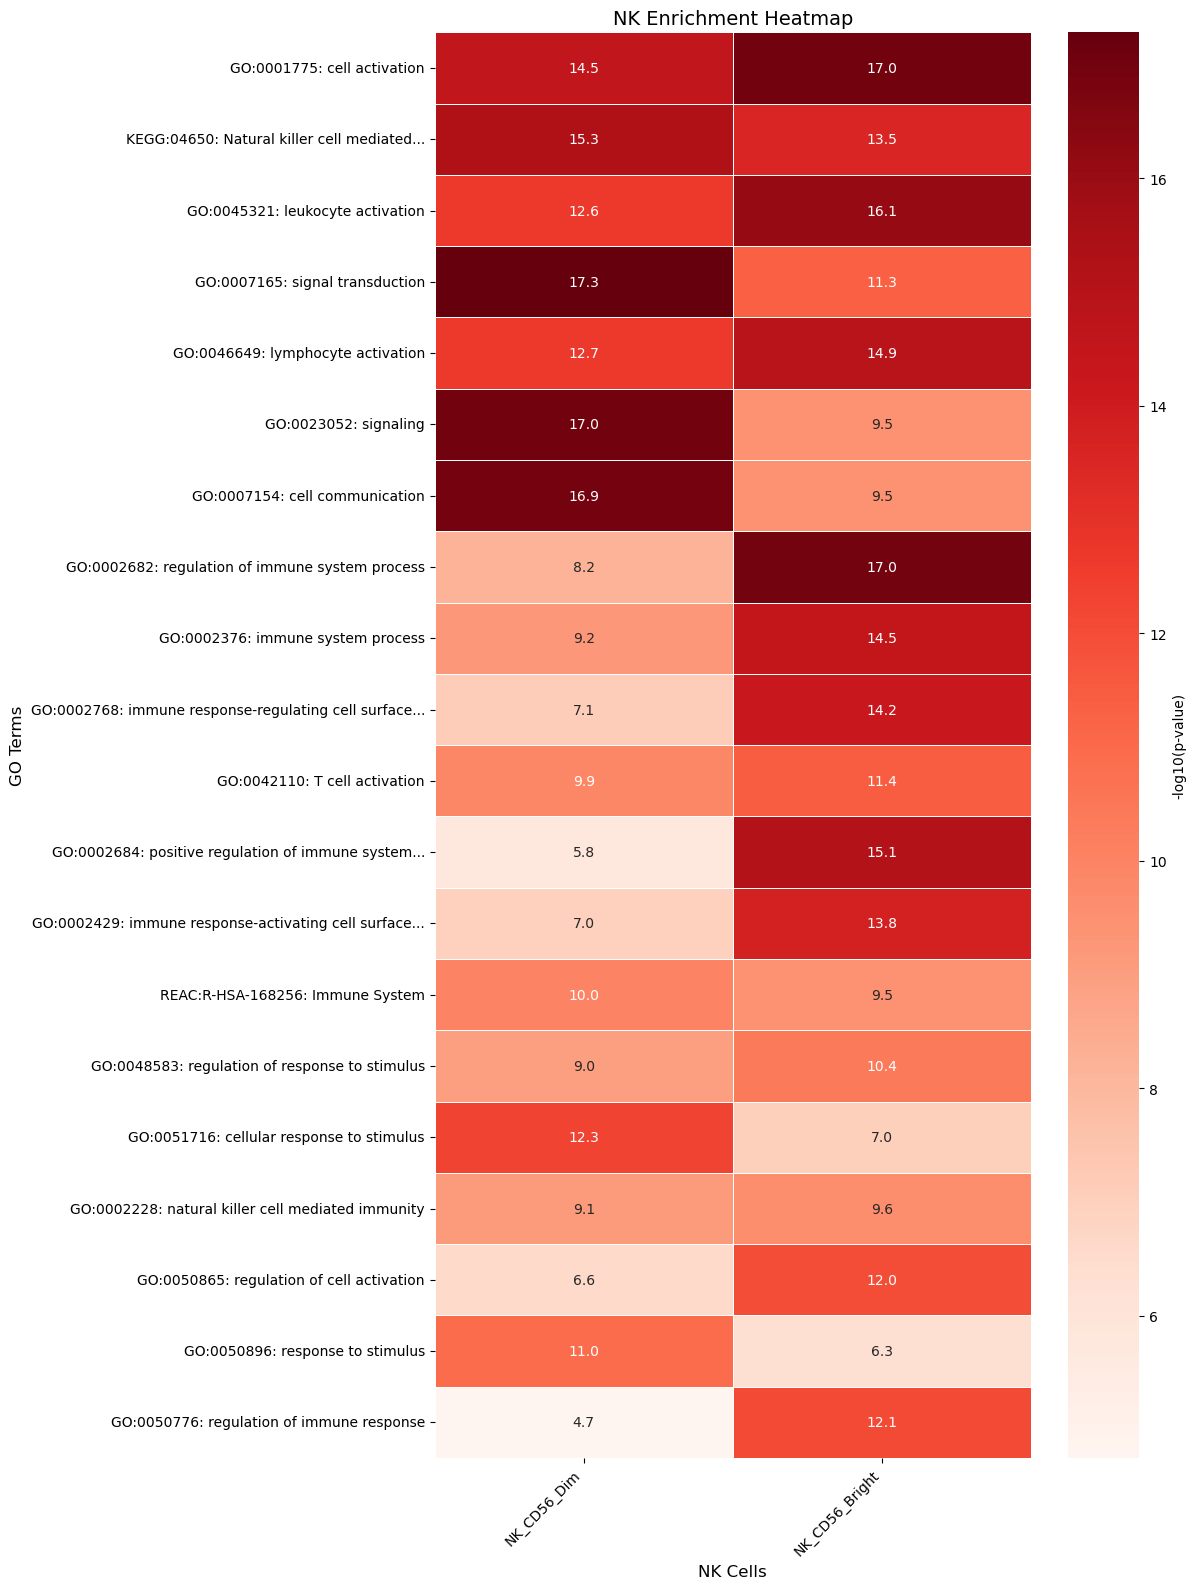

In [83]:
go_analysis_nk_bp_only = deg_marker_go(compare_nk_cells[:-1], adata, source=["GO:BP", "KEGG", "REAC"])
plot_go_heatmap(go_analysis_nk_bp_only, title="NK Enrichment Heatmap", title_cells="NK Cells")
plt.savefig('NK_low_dim_go_enrichment_heatmap_total_bp_kegg_reac.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


AnnData object with n_obs × n_vars = 99249 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'
[AAACCTGAGGCGTACA-1-sample42    False
AAACCTGAGGGAGTAA-1-sample42    False


INFO:__main__:Processing cell type: Monocytes_CD16
INFO:__main__:Running GO enrichment for: Monocytes_CD16


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for Monocytes_CD16
INFO:__main__:Processing cell type: Monocytes_CD14
INFO:__main__:Running GO enrichment for: Monocytes_CD14


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for Monocytes_CD14


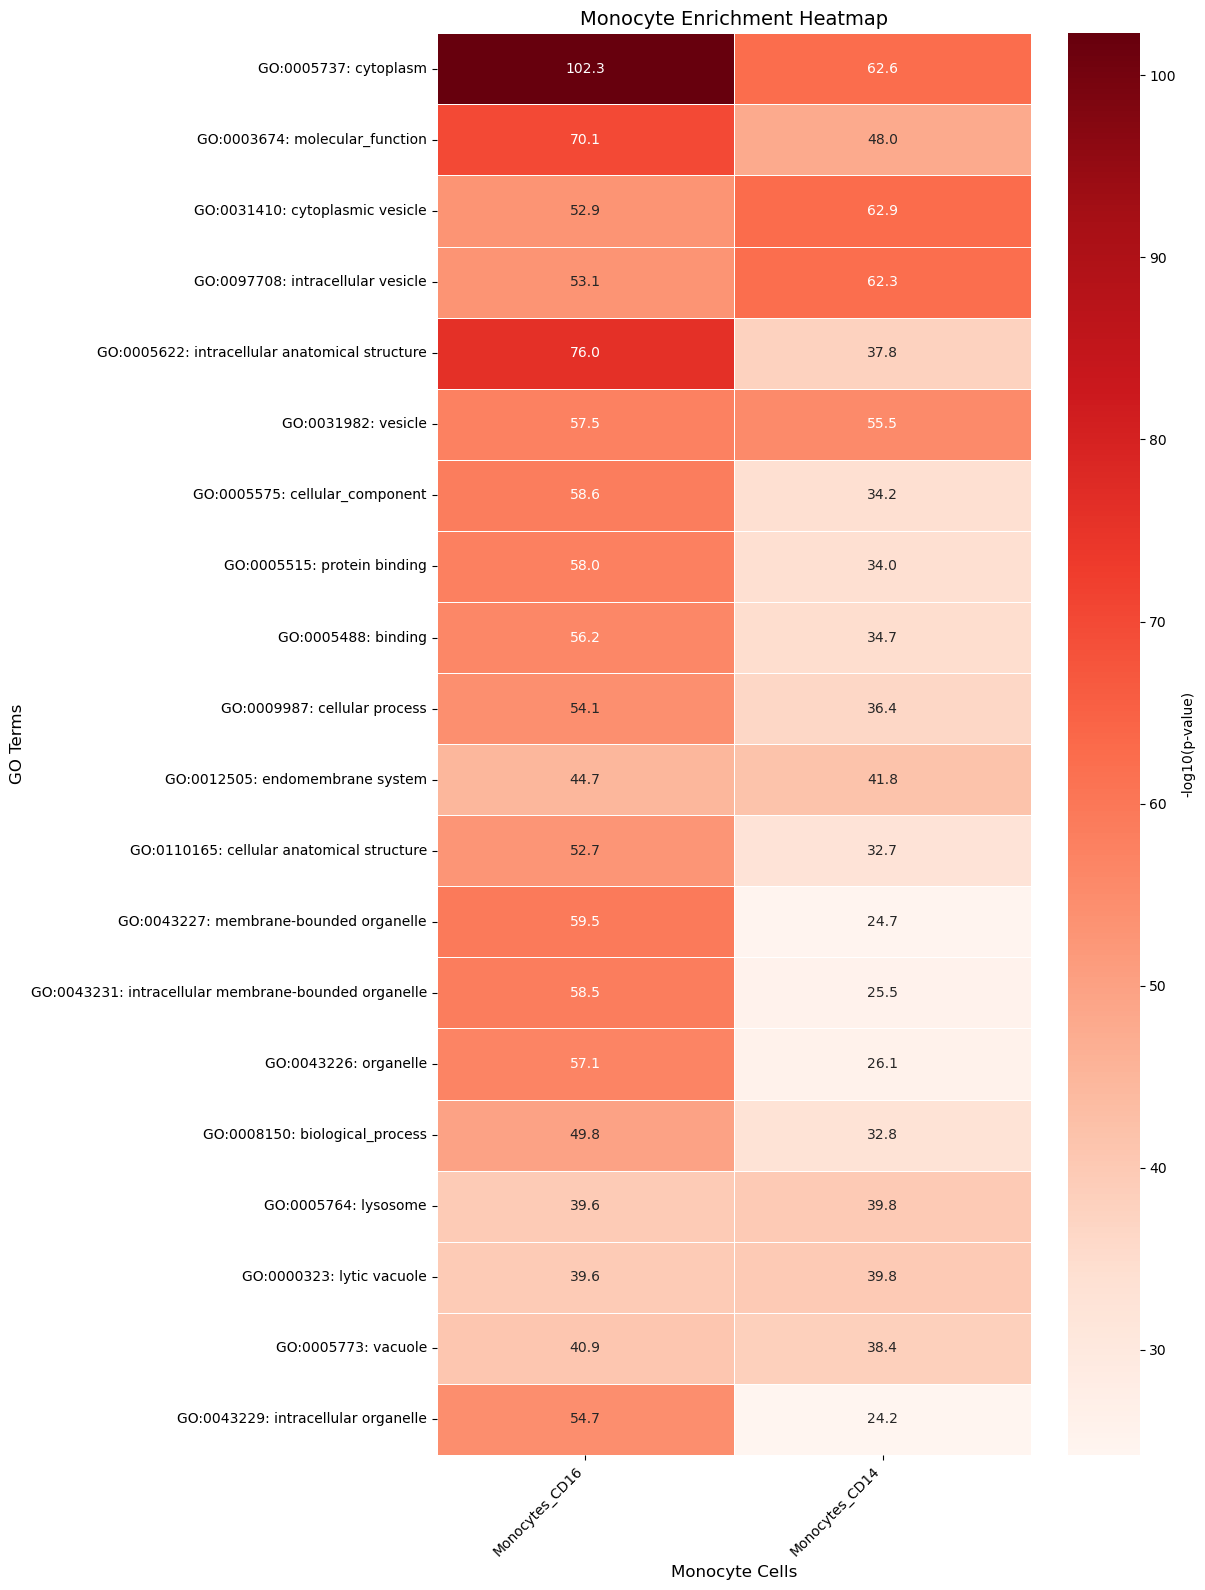

In [82]:
compare_mono = ["Monocytes_CD16", "Monocytes_CD14"]
go_analysis_monocytes = deg_marker_go(compare_mono, adata)
plot_go_heatmap(go_analysis_monocytes, title="Monocyte Enrichment Heatmap", title_cells="Monocyte Cells")
plt.savefig('monocyte_go_enrichment_heatmap_final_total.png', dpi=300, bbox_inches='tight')
plt.show()

INFO:__main__:Running rank_genes_groups on secondary_type


AnnData object with n_obs × n_vars = 407033 × 22091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.HB', 'percent.RPS', 'S.Score', 'G2M.Score', 'Phase', 'umis_TCR', 'umis_BCR', 'primary_type', 'secondary_type', 'sequential_group', 'eight_group', 'sampleName', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'version', 'log1p', 'rank_genes_groups'
    layers: 'RNA_counts', 'RNA_data'
[AAACCTGAGGCGTACA-1-sample42    True
AAACCTGAGGGAGTAA-1-sample42    True
A

INFO:__main__:Processing cell type: NK_CD56_Dim
INFO:__main__:Running GO enrichment for: NK_CD56_Dim


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for NK_CD56_Dim
INFO:__main__:Processing cell type: NK_CD56_Bright
INFO:__main__:Running GO enrichment for: NK_CD56_Bright


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for NK_CD56_Bright
INFO:__main__:Processing cell type: NK_Proliferating
INFO:__main__:Running GO enrichment for: NK_Proliferating


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for NK_Proliferating
INFO:__main__:Processing cell type: CD4_Naive_CCR7
INFO:__main__:Running GO enrichment for: CD4_Naive_CCR7


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_Naive_CCR7
INFO:__main__:Processing cell type: CD4_TCM_AQP3
INFO:__main__:Running GO enrichment for: CD4_TCM_AQP3


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_TCM_AQP3
INFO:__main__:Processing cell type: CD4_TEM_ANXA1
INFO:__main__:Running GO enrichment for: CD4_TEM_ANXA1


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_TEM_ANXA1
INFO:__main__:Processing cell type: CD4_TEM_GNLY
INFO:__main__:Running GO enrichment for: CD4_TEM_GNLY


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_TEM_GNLY
INFO:__main__:Processing cell type: CD4_Treg_FOXP3
INFO:__main__:Running GO enrichment for: CD4_Treg_FOXP3


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD4_Treg_FOXP3
INFO:__main__:Processing cell type: CD8_TEM_GNLY
INFO:__main__:Running GO enrichment for: CD8_TEM_GNLY


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TEM_GNLY
INFO:__main__:Processing cell type: CD8_Naive_LEF1
INFO:__main__:Running GO enrichment for: CD8_Naive_LEF1


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_Naive_LEF1
INFO:__main__:Processing cell type: CD8_TEM_CMC1
INFO:__main__:Running GO enrichment for: CD8_TEM_CMC1


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TEM_CMC1
INFO:__main__:Processing cell type: CD8_MAIT_SLC4A10
INFO:__main__:Running GO enrichment for: CD8_MAIT_SLC4A10


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_MAIT_SLC4A10
INFO:__main__:Processing cell type: CD8_TEM_ZNF683
INFO:__main__:Running GO enrichment for: CD8_TEM_ZNF683


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TEM_ZNF683
INFO:__main__:Processing cell type: CD8_TCM_HAVCR2
INFO:__main__:Running GO enrichment for: CD8_TCM_HAVCR2


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for CD8_TCM_HAVCR2
INFO:__main__:Processing cell type: B_BCR_GNLY
INFO:__main__:Running GO enrichment for: B_BCR_GNLY


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_BCR_GNLY
INFO:__main__:Processing cell type: B_Memory
INFO:__main__:Running GO enrichment for: B_Memory


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_Memory
INFO:__main__:Processing cell type: B_Atypical_Memory
INFO:__main__:Running GO enrichment for: B_Atypical_Memory


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_Atypical_Memory
INFO:__main__:Processing cell type: B_Naive
INFO:__main__:Running GO enrichment for: B_Naive


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for B_Naive
INFO:__main__:Processing cell type: Plasma cell
INFO:__main__:Running GO enrichment for: Plasma cell


marker genes:
['GO:BP', 'GO:MF', 'GO:CC']


INFO:__main__:Saving GO results for Plasma cell


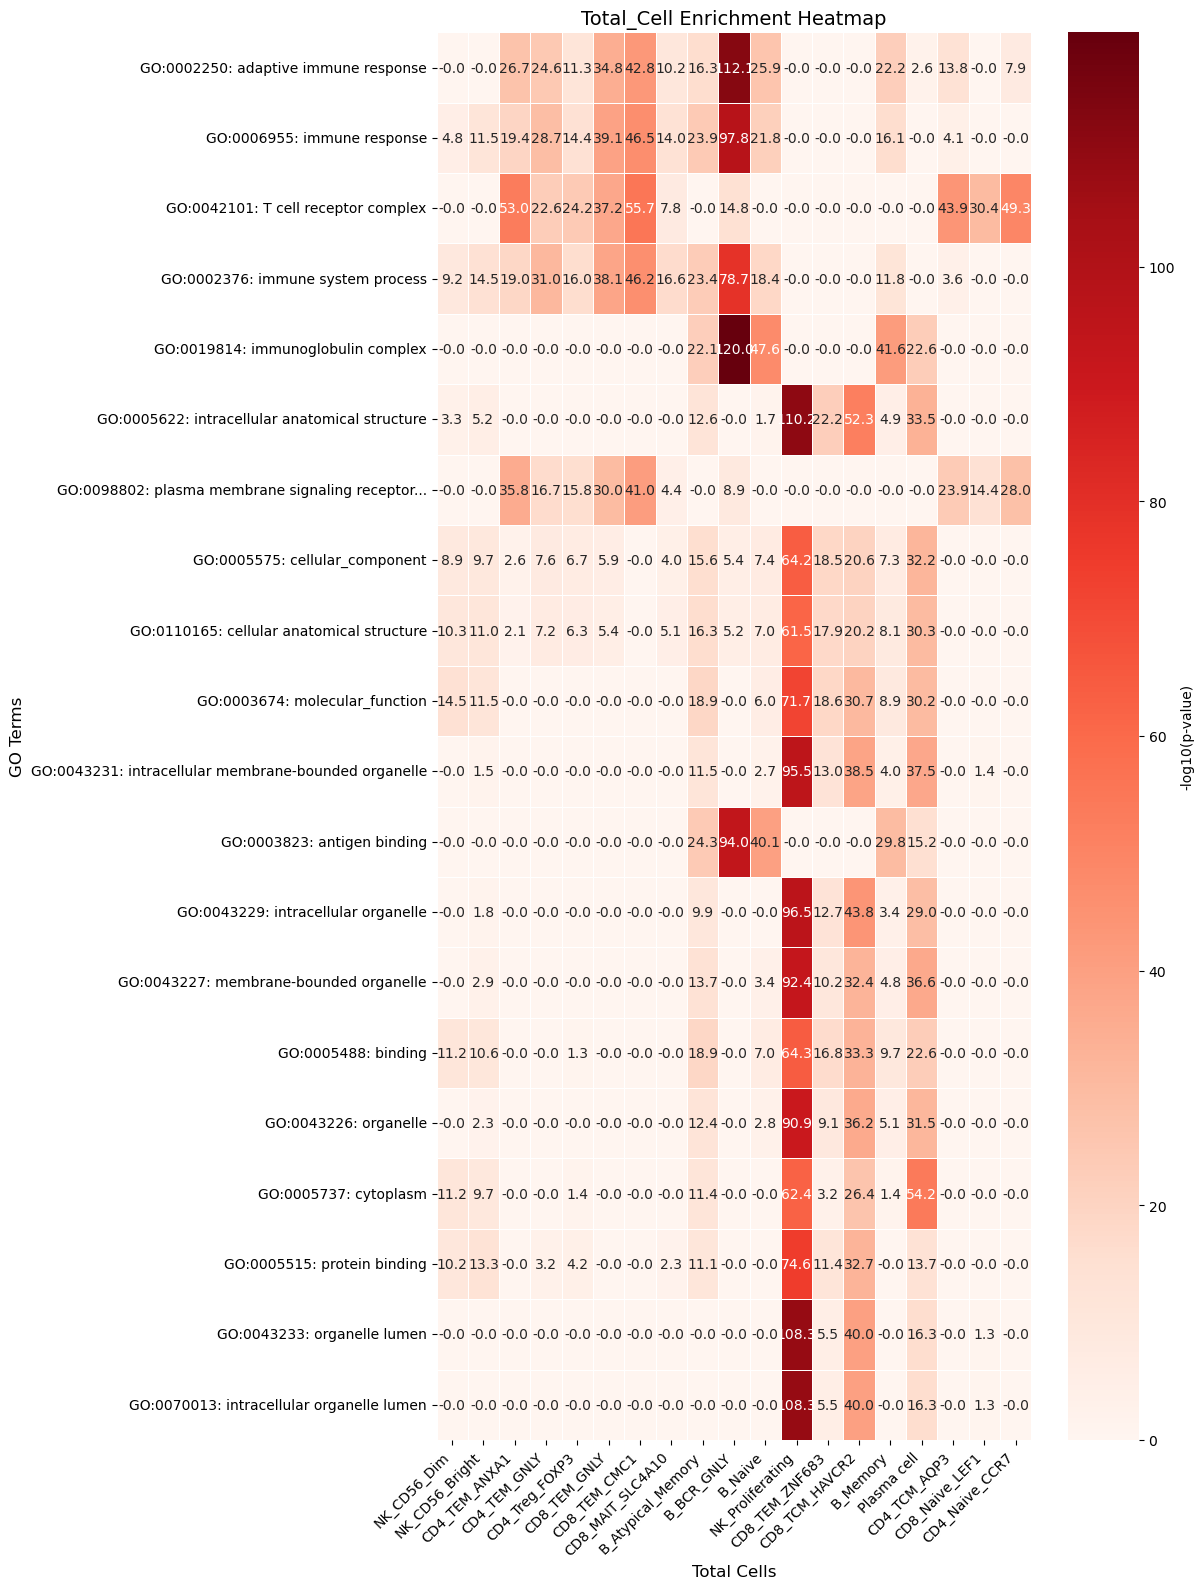

In [78]:
go_analysis_total = deg_marker_go(compare_nk_cells+compare_cd4_cells+compare_cd8_cells+b_cell_types, adata)
plot_go_heatmap(go_analysis_total, title="Total_Cell Enrichment Heatmap", title_cells="Total Cells")
plt.savefig('total_call_go_enrichment_heatmap_final_total.png', dpi=300, bbox_inches='tight')
plt.show()

In [113]:
sec_types = adata.obs["secondary_type"].unique()
print(sec_types)

['CD4_TEM_ANXA1', 'CD8_TEM_GNLY', 'B_Memory', 'NK_CD56_Dim', 'B_Naive', ..., 'CD8_TCM_HAVCR2', 'B_BCR_GNLY', 'CD8_TEM_ZNF683', 'mDC', 'Plasma cell']
Length: 25
Categories (25, object): ['B_Atypical_Memory', 'B_BCR_GNLY', 'B_Memory', 'B_Naive', ..., 'Plasma cell', 'gdT', 'mDC', 'pDC']


In [81]:
#check B cell list
print(results_dict)

{'B_BCR_GNLY':    source      native                                          name  \
0   GO:BP  GO:0002250                      adaptive immune response   
1   GO:BP  GO:0006955                               immune response   
2   GO:BP  GO:0002376                         immune system process   
3   GO:BP  GO:0016064       immunoglobulin mediated immune response   
4   GO:BP  GO:0019724                      B cell mediated immunity   
..    ...         ...                                           ...   
88  GO:BP  GO:0007093       mitotic cell cycle checkpoint signaling   
89  GO:BP  GO:0032944  regulation of mononuclear cell proliferation   
90  GO:BP  GO:0050851   antigen receptor-mediated signaling pathway   
91  GO:BP  GO:0030261                       chromosome condensation   
92  GO:BP  GO:0070661                       leukocyte proliferation   

          p_value  significant  \
0   1.622081e-115         True   
1    2.236899e-89         True   
2    1.627977e-75         True

### Age Groups Test

In [84]:
adata.obs['eight_group'].value_counts()


eight_group
30-40y      83384
12-18y      76428
70-80y      66247
1-2y        65657
50-60y      63728
6y          62950
0y          44973
90y         34644
pregnant    34063
Name: count, dtype: int64

In [85]:
celltype_counts = adata.obs.groupby(['eight_group', 'secondary_type']).size().unstack(fill_value=0)


/tmp/ipykernel_2294059/1182306374.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts = adata.obs.groupby(['eight_group', 'secondary_type']).size().unstack(fill_value=0)


In [86]:
celltype_props = celltype_counts.div(celltype_counts.sum(axis=1), axis=0)


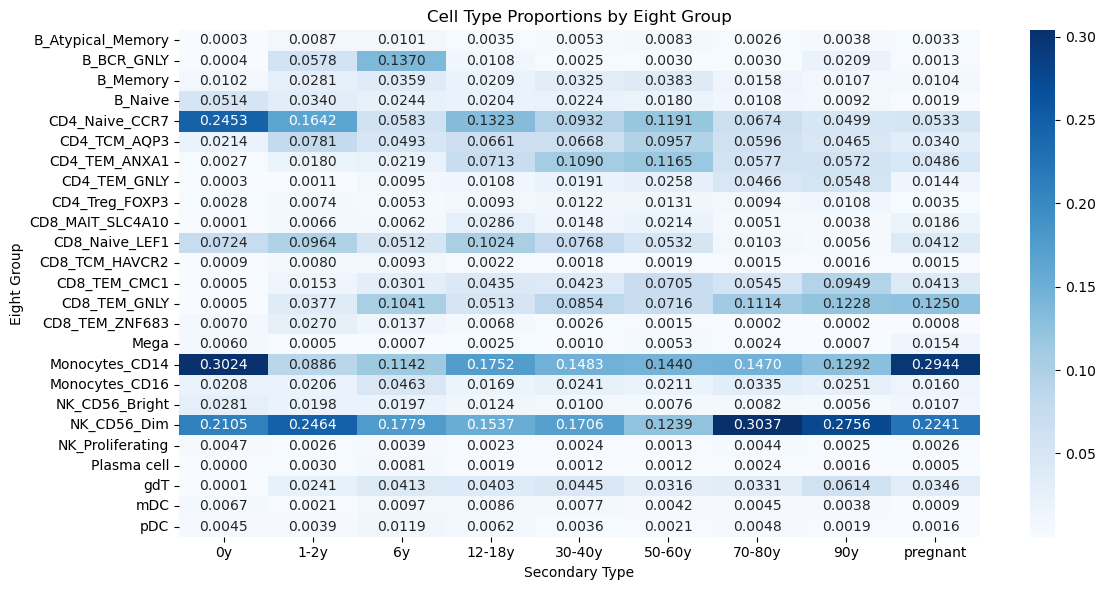

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(celltype_props.T, cmap='Blues', annot=True, fmt=".4f")
plt.title("Cell Type Proportions by Eight Group")
plt.ylabel("Eight Group")
plt.xlabel("Secondary Type")
plt.tight_layout()
plt.savefig('cell_proportions_per_age_group.png', dpi=600)
plt.show()


In [149]:
gp = GProfiler(return_dataframe=True)
results_by_agegroup = {}

#DE per age group
sc.tl.rank_genes_groups(adata, groupby='eight_group', method='wilcoxon')

#per age group
for age_group in adata.obs['eight_group'].unique():
    print(f"Processing: {age_group}")

    # Get marker genes for that group
    marker_df = sc.get.rank_genes_groups_df(adata, group=age_group)

    # Filter significant upregulated genes
    filtered = marker_df[
        (marker_df['pvals_adj'] < 0.25) &
        (marker_df['logfoldchanges'] > 0.5)
    ]
    gene_list = filtered['names'].tolist()

    if not gene_list:
        print(f"Skipping {age_group}, no DEGs found.")
        continue

    #all genes in dataset
    expressed_genes = adata.raw.var_names.tolist() if adata.raw else adata.var_names.tolist()

    #enrichment profile
    go_result = gp.profile(
        organism='hsapiens',
        query=gene_list,
        sources=["GO:BP", "GO:MF", "GO:CC"],
        domain_scope="custom",
        background=expressed_genes
    )

    results_by_agegroup[age_group] = go_result

Processing: 50-60y
Processing: pregnant
Processing: 0y
Processing: 1-2y
Processing: 6y
Processing: 12-18y
Processing: 30-40y
Processing: 70-80y
Processing: 90y


In [150]:
# Collect top N terms per group
top_n = 5
all_ids = []

for group, df in results_by_agegroup.items():
    if not df.empty:
        top_ids = df.nsmallest(top_n, 'p_value')['native'].tolist()
        all_ids += top_ids

# Unique set of all IDs to plot
unique_ids = list(set(all_ids))

# Initialize heatmap matrix
heatmap_data = pd.DataFrame(index=unique_ids, columns=ordered_age_groups)

# Fill with –log10(p-value)
for group, df in results_by_agegroup.items():
    for term_id in unique_ids:
        match = df[df['native'] == term_id]
        if not match.empty:
            pval = match.iloc[0]['p_value']
            heatmap_data.loc[term_id, group] = -np.log10(pval) if pval > 0 else 300
        else:
            heatmap_data.loc[term_id, group] = 0.0

heatmap_data = heatmap_data.fillna(0).astype(float)


/tmp/ipykernel_2294059/2330905865.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(float)


In [151]:
print(heatmap_data.head())


             pregnant         0y       1-2y         6y    12-18y  30-40y  \
GO:0006754   0.000000   0.000000   0.000000   0.000000  5.162519     0.0   
GO:0023052  18.191639  14.389439   0.000000   3.126810  0.000000     0.0   
GO:0099503  47.143339  20.298675   0.000000   0.000000  0.000000     0.0   
GO:0042776   0.000000   0.000000   0.000000   0.000000  5.334409     0.0   
GO:0002376  33.421074  21.492945  14.873258  42.383282  0.000000     0.0   

              50-60y    70-80y        90y  
GO:0006754  0.000000  0.000000   0.000000  
GO:0023052  0.000000  5.154250   8.447610  
GO:0099503  0.000000  0.000000   0.000000  
GO:0042776  0.000000  0.000000   0.000000  
GO:0002376  5.496778  4.930415  16.007741  


In [152]:
print(results_by_agegroup)

{'50-60y':    source      native                                               name  \
0   GO:BP  GO:0002250                           adaptive immune response   
1   GO:CC  GO:0042101                            T cell receptor complex   
2   GO:BP  GO:0006955                                    immune response   
3   GO:BP  GO:0002376                              immune system process   
4   GO:CC  GO:0071944                                     cell periphery   
5   GO:CC  GO:0098802         plasma membrane signaling receptor complex   
6   GO:CC  GO:0005886                                    plasma membrane   
7   GO:BP  GO:0050896                               response to stimulus   
8   GO:MF  GO:0019956                                  chemokine binding   
9   GO:CC  GO:0043235                                   receptor complex   
10  GO:BP  GO:0032946  positive regulation of mononuclear cell prolif...   
11  GO:MF  GO:0016493                    C-C chemokine receptor activity   
1

In [153]:
results_by_agegroup["30-40y"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


/tmp/ipykernel_2294059/78656433.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  example_df = pd.concat(results_by_agegroup.values()).drop_duplicates('native')


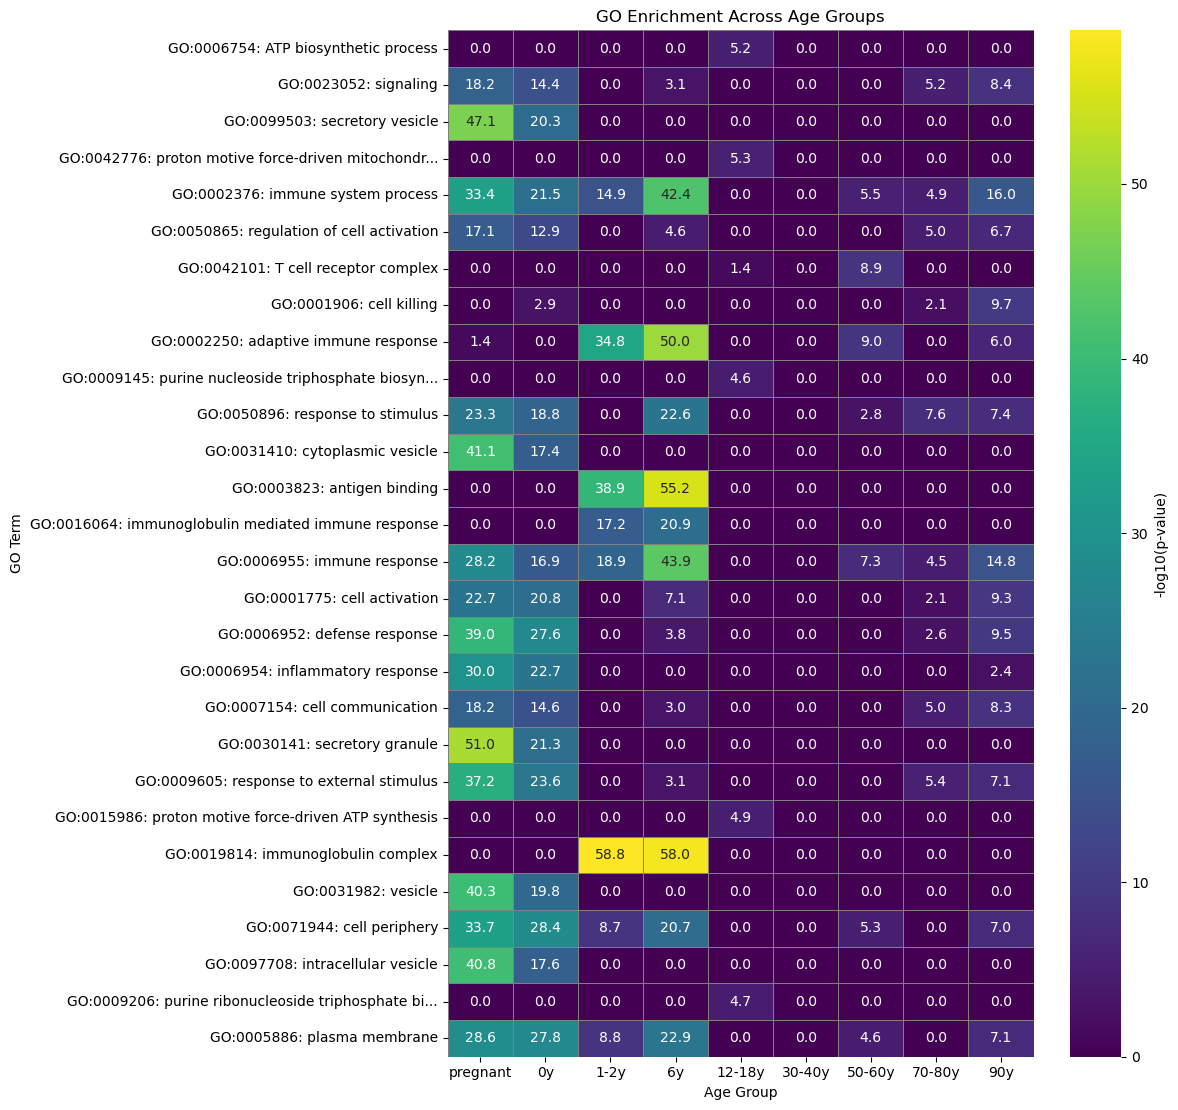

In [154]:
ordered_age_groups = [
    "pregnant", "0y", "1-2y", "6y", "12-18y",
    "30-40y", "50-60y", "70-80y", "90y"
]

#reorder
heatmap_data = heatmap_data[[col for col in ordered_age_groups if col in heatmap_data.columns]]

#format term for display
def format_term(go_id, desc, max_length=40):
    desc = str(desc) if desc else ""
    short_desc = desc if len(desc) <= max_length else desc[:max_length - 3] + '...'
    return f"{go_id}: {short_desc}"


example_df = pd.concat(results_by_agegroup.values()).drop_duplicates('native')
id_to_name = dict(zip(example_df['native'], example_df['name']))

#re_index
heatmap_data.index = [
    format_term(term_id, id_to_name.get(term_id, ""))
    for term_id in heatmap_data.index
]

plt.figure(figsize=(12, len(heatmap_data) * 0.4))
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    linewidths=0.5,
    linecolor='gray',
    annot=True,
    fmt=".1f",
    cbar_kws={'label': '-log10(p-value)'}
)
plt.title("GO Enrichment Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("GO Term")
plt.tight_layout()
plt.savefig("heatmap_eight_group_go_final.png", dpi=1200)
plt.show()
